# Graph based Music Recommender

In this assignments you will build a music recommender engine based on user’s playlists history. For Tasks 1-4 you will use dataframes that represent the weight of edges count the collaborative similarity between the vertices. Task 5-6 takes steps forward to fully implement the recommender system described in the lectures.

## Data description
There are two data sources for this assignment. They are DataFrames in parquet format.

**The first dataset captures the user’s playing history.**

*Location - /data/sample264*

Fields: *trackId, userId, timestamp, artistId*

- trackId - id of the track
- userId - id of the user
- artistId - id of the artist
- timestamp - timestamp of the moment the user starts listening to a track

**The second is the meta data for track or artist.**

*Location - /data/meta*

Fields: *type, Name, Artist, Id*

- Type could be “track” or “artist”
- Name is the title of the track, if the type == “track” and the name of the musician or group, if the type == “artist”.
- Artist states for the creator of the track in case the type == “track” and for the name of the musician or group in case the type == “artist”.
- Id - id of the item

**NB.** Each subsequent of these tasks is a continuation of the previous one. So, you may use the same ipython notebook for all the programming assignments in this week.

### Graph based Music Recommender. Task 1
Build the edges of the type “track-track”. To do it you will need to count the collaborative similarity between all the tracks: if a user has started listening to track B within 7 minutes after starting track A, then you should add 1 to the weight of the edge from vertex A to vertex B (initial weight is equal to 0).

Example:

`userId artistId trackId timestamp
7        12        1          1534574189
7        13        4          1534574289 
5        12        1          1534574389 
5        13        4          1534594189 
6        12        1          1534574489 
6        13        4          1534574689` 

The track 1 is similar to the track 4 with the weight 2 (before normalization): the user 7 and the user 6 listened these 2 tracks together in the 7 minutes long window:

- userId 7: 1534574289 - 1534574189 = 100 seconds = 1 min 40 seconds < 7 minutes
- userId 6: 1534574689 - 1534574489 = 200 seconds = 3 min 20 seconds < 7 minutes
Note that the track 4 is similar to the track 1 with the same weight 2.

**Tip:** consider joining the graph to itself with the UserId and remove pairs with the same tracks.For each track choose top 50 tracks ordered by weight similar to it and normalize weights of its edges (divide the weight of each edge on a sum of weights of all edges). Use rank() to choose top 40 tracks as is done in the demo.

Sort the resulting Data Frame in the descending order by the column norm_weight, and then in the ascending order this time first by “id1”, then by “id2”. Take top 40 rows, select only the columns “id1”, “id2”, and print the columns “id1”, “id2” of the resulting dataframe.

**Output example:**

`54719		767867
54719		767866
50787		327676`

In [2]:
#import os
#execfile(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.1.1
      /_/

Using Python version 2.7.12 (default, Nov 19 2016 06:48:10)
SparkSession available as 'spark'.


In [3]:
from pyspark.sql import SparkSession
sparkSession = SparkSession.builder.enableHiveSupport().master("local").getOrCreate()

In [38]:
data = sparkSession.read.parquet("/data/sample264")
meta = sparkSession.read.parquet("/data/meta")

In [134]:
alpha = 0.15
beta_user_artist = 0.5
beta_user_track = 0.5
beta_track_track = 1
beta_artist_track = 1

user = 776748

In [136]:
from pyspark.sql import Window
from pyspark.sql.functions import row_number, sum, col, abs, count, desc, asc, when, expr, lit, rank, round

In [5]:
def norm(df, key1, key2, field, n): 
    
    window = Window.partitionBy(key1).orderBy(col(field).desc())
    
    topsDF = df.withColumn("row_number", row_number().over(window)) \
        .filter(col("row_number") <= n) \
        .drop(col("row_number")) 

    tmpDF = topsDF.groupBy(col(key1)).agg(col(key1), sum(col(field)).alias("sum_" + field))

    normalizedDF = topsDF.join(tmpDF, key1, "inner") \
        .withColumn("norm_" + field, col(field) / col("sum_" + field)) \
        .cache()

    return normalizedDF

In [31]:
from pyspark.sql.functions import collect_list, col, abs, count, rank

In [32]:
data1 = data.select(col("userId"), col("trackId").alias("trackId1"), col("timestamp").alias("timestamp1"));
    
data2 = data.select(col("userId"), col("trackId").alias("trackId2"), col("timestamp").alias("timestamp2"));

#joining the graph to itself with the UserId
#...and remove pairs with the same tracks.
similarityDF = data1.join(data2, "userId", "inner")\
    .filter(abs(col("timestamp1")-col("timestamp2"))/60 <= 7)\
    .filter(col("trackId1") != col("trackId2"))\
    .groupBy(col('trackId1'), col('trackId2'))\
    .count().alias('count')\
    .cache();

In [114]:
#choose top 50 tracks ordered by weight similar to it and normalize weights of its edges
trackTrackNorm = norm(similarityDF, "trackId1", "trackId2", "count", 50);

In [115]:
window = Window.orderBy(col("norm_count").desc())

#Sort the resulting Data Frame in the descending order by the column norm_weight, 
#and then in the ascending order this time first by “id1”, then by “id2”. 
#Take top 40 rows, select only the columns “id1”, “id2”, and print the columns “id1”, “id2” of the resulting dataframe.    
similarTrackList = trackTrackNorm.withColumn("position", rank().over(window)) \
    .orderBy(col("norm_count"), col("trackId1"), col("trackId2"))\
    .select(col("trackId1"), col("trackId2"))\
    .filter(col("position") < 50)\
    .take(40);

In [220]:
#For Task 1
#for val in result:
#    print('%s %s' % val);

In [116]:
#For Task 6
norm_weights = trackTrackNorm\
    .withColumn("next_value", col("norm_count") * beta_track_track);

trackTrack = (norm_weights\
    .select(col("trackId1").alias("Id1"), col("trackId2").alias("Id2"), col("next_value"))).cache();

### Graph based Music Recommender. Task 2

Build the edges of the type “user-track”. Take the amount of times the track was listened by the user as the weight of the edge from the user’s vertex to the track’s vertex.

**Tip:** group the dataframe by columns userId and trackId and use function “count” of DF API.

For each user take top-1000 and normalize them.

Sort the resulting Data Frame in descending order by the column norm_weight, and then in ascending order this time first by “id1”, then by “id2”. Take top 40 rows, select only the columns “id1”, “id2”, and print the columns “id1”, “id2” of the resulting dataframe.

**The part of the result on the sample dataset:**

`...
195 946408
215 860111
235 897176
300 857973
321 915545
...`

In [120]:
#group the dataframe by columns userId and trackId and use function “count” of DF API.
userTrack = data.groupBy(col("userId"), col("trackId")).count();

In [121]:
#For each user take top-1000 and normalize them.
#Sort the resulting Data Frame in descending order by the column norm_weight, 
#and then in ascending order this time first by “id1”, then by “id2”.
userTrackNorm = (norm(userTrack, "userId", "trackId", "count", 1000) \
    .orderBy(col("norm_count").desc(), col("userId"), col("trackId")))\
    .cache();    

In [122]:
window = Window.orderBy(col("norm_count"));

#Take top 40 rows, select only the columns “id1”, “id2”, and print the columns “id1”, “id2” of the resulting dataframe.
userTrackList = userTrackNorm.withColumn("position", rank().over(window))\
    .filter(col("position") < 50)\
    .select(col("userId").alias("id1"), col("trackId").alias("id2"))\
    .take(40);

In [117]:
#for val in userTrackList:
#    print ("%s %s" % val)

In [123]:
#For Task 6
norm_weights = userTrackNorm\
    .withColumn("next_value", col("norm_count") * beta_user_track);

userTrack = (norm_weights\
    .select(col("userId").alias("Id1"), col("trackId").alias("Id2"), col("next_value"))).cache();

### Graph based Music Recommender. Task 3
Build the edges of the type “user-artist”. Take the amount of times the user has listened to the artist’s tracks as the weight of the edge from the user’s vertex to the artist’s vertex.

**Tip:** group the dataframe by the columns userId and trackId and use the function “count” of DF API. For each user take top-100 artists and normalize weights.

Sort the resulting Data Frame in descending order by the column norm_weight, and then in ascending order this time first by “id1”, then by “id2”. Take top 40 rows, select only the columns “id1”, “id2”, and print the columns “id1”, “id2” of the resulting dataframe.

**The part of the result on the sample dataset:**

`...
131 983068
195 997265
215 991696
235 990642
288 1000564
...`

In [126]:
userArtist = data.groupBy(col("userId"), col("artistId")).count();

In [127]:
userArtistNorm = (norm(userArtist, "userId", "artistId", "count", 100)\
                  .orderBy(col("norm_count").desc(), col("userId"), col("artistId"))).cache();

In [25]:
window = Window.orderBy(col("norm_count"));

userArtistList = userArtistNorm.withColumn("position", rank().over(window))\
    .filter(col("position") < 40)\
    .select(col("userId").alias("id1"), col("artistId").alias("id2"))\
    .take(40);

In [124]:
#for val in userArtistList:
#    print ("%s %s" % val)

In [128]:
#For Task 6
norm_weights = userArtistNorm\
    .withColumn("next_value", col("norm_count") * beta_user_artist);

userArtist = (norm_weights\
    .select(col("userId").alias("Id1"), col("artistId").alias("Id2"), col("next_value"))).cache();

### Graph based Music Recommender. Task 4

Build the edges of the type “artist-track”. Take the amount of times the track HAS BEEN listened by all users as the weight of the edge from the artist’s vertex to the track’s vertex.

**Tip:** group the dataframe by the columns “artistId” and “trackId” and use the function “count” of DF API. For each artist take top-100 tracks and normalize weights.

Sort the resulting Data Frame in descending order by the column norm_weight, and then in ascending order this time first by “id1”, then by “id2”. Take top 40 rows, select only the columns “id1”, “id2”, and print the columns “id1”, “id2” of the resulting dataframe.

**The part of the result on the sample dataset:**

`...
968017 859321
968022 852786
968034 807671
968038 964150
968042 835935
...`

In [130]:
artistTrack = data.groupBy(col("artistId"), col("trackId")).count();

artistTrackNorm = (norm(artistTrack, "artistId", "trackId", "count", 100)\
                   .orderBy(col("norm_count").desc(), col("artistId"), col("trackId"))\
                   .limit(40)).cache();

artistTrackList = artistTrackNorm.select(col("artistId").alias("id1"), col("trackId").alias("id2")).take(40);

In [129]:
#for val in artistTrackList:
#    print ("%s %s" % val)

In [131]:
#For Task 6
norm_weights = artistTrackNorm\
    .withColumn("next_value", col("norm_count") * beta_artist_track);

artistTrack = (norm_weights\
    .select(col("artistId").alias("Id1"), col("trackId").alias("Id2"), col("next_value"))).cache();

### Graph based Music Recommender. Task 5

For the user with Id 776748 find all the tracks and artists connected to him. Use original dataframe not a normalized one. Sort founded items first by artist then by name in ascending order, leave only columns ”Artist” and “Name” and print top-40.

Each output line can take one of the following forms:

1. Artist: <artist-name> <track-name>
2. Artist: <artist-name> Artist: <artist-name>

These two forms help distinguish “user-track” suggestions (as shown in 1) from “user-artist” suggestions (as shown in 2).

**part of the result on the sample dataset:**
    
`...
Artist: Blur Artist: Blur
Artist: Blur Girls and Boys
Artist: Clawfinger Artist: Clawfinger
Artist: Clawfinger Nothing Going On
Artist: Disturbed Artist: Disturbed
...`

In [108]:
userData = data.filter(col("userId") == 776748);

artists = userData.select(col("artistId").alias("Id")).distinct();

tracks = userData.select(col("trackId").alias("Id")).distinct();

userArtistsTracks = (artists.union(tracks)\
    .join(meta, "Id", "inner")\
    .orderBy(col("Artist"), col("Name"))\
    .select(col("Artist"), col("Name"))).cache()\
    .take(40);

In [109]:
#for val in userArtistsTracks:
#    print ("%s %s" % val)

Artist: 3 Doors Down Artist: 3 Doors Down
Artist: 3 Doors Down Kryptonite
Artist: 311 Artist: 311
Artist: 311 Beautiful disaster
Artist: Blur Artist: Blur
Artist: Blur Girls and Boys
Artist: Clawfinger Artist: Clawfinger
Artist: Clawfinger Nothing Going On
Artist: Disturbed Artist: Disturbed
Artist: Disturbed The Vengeful One
Artist: Gotthard Artist: Gotthard
Artist: Gotthard Eagle
Artist: Green Day 21 Guns
Artist: Green Day Artist: Green Day
Artist: Green Day Kill The DJ
Artist: Iggy Pop Artist: Iggy Pop
Artist: Iggy Pop Sunday
Artist: Korn Artist: Korn
Artist: Korn Here To Stay
Artist: Linkin Park Artist: Linkin Park
Artist: Linkin Park In The End
Artist: Linkin Park Numb
Artist: Lordi Artist: Lordi
Artist: Lordi Hard Rock Hallelujah
Artist: Nickelback Artist: Nickelback
Artist: Nickelback She Keeps Me Up
Artist: Nomy Artist: Nomy
Artist: Nomy Cocaine
Artist: Papa Roach Artist: Papa Roach
Artist: Papa Roach Getting Away With Murder
Artist: Rise Against Artist: Rise Against
Artist: Ri

### Graph based Music Recommender. Task 6

For the user with Id 776748 print top-40 recommended tracks. Build music recommendations with the algorithm described in the lesson 3 of the fifth week. Initialize coordinates of vector x_0 corresponding to the user’s vertex and all the vertices from the task 5 with ones and all other coordinates with zeros. Do 5 iterations:

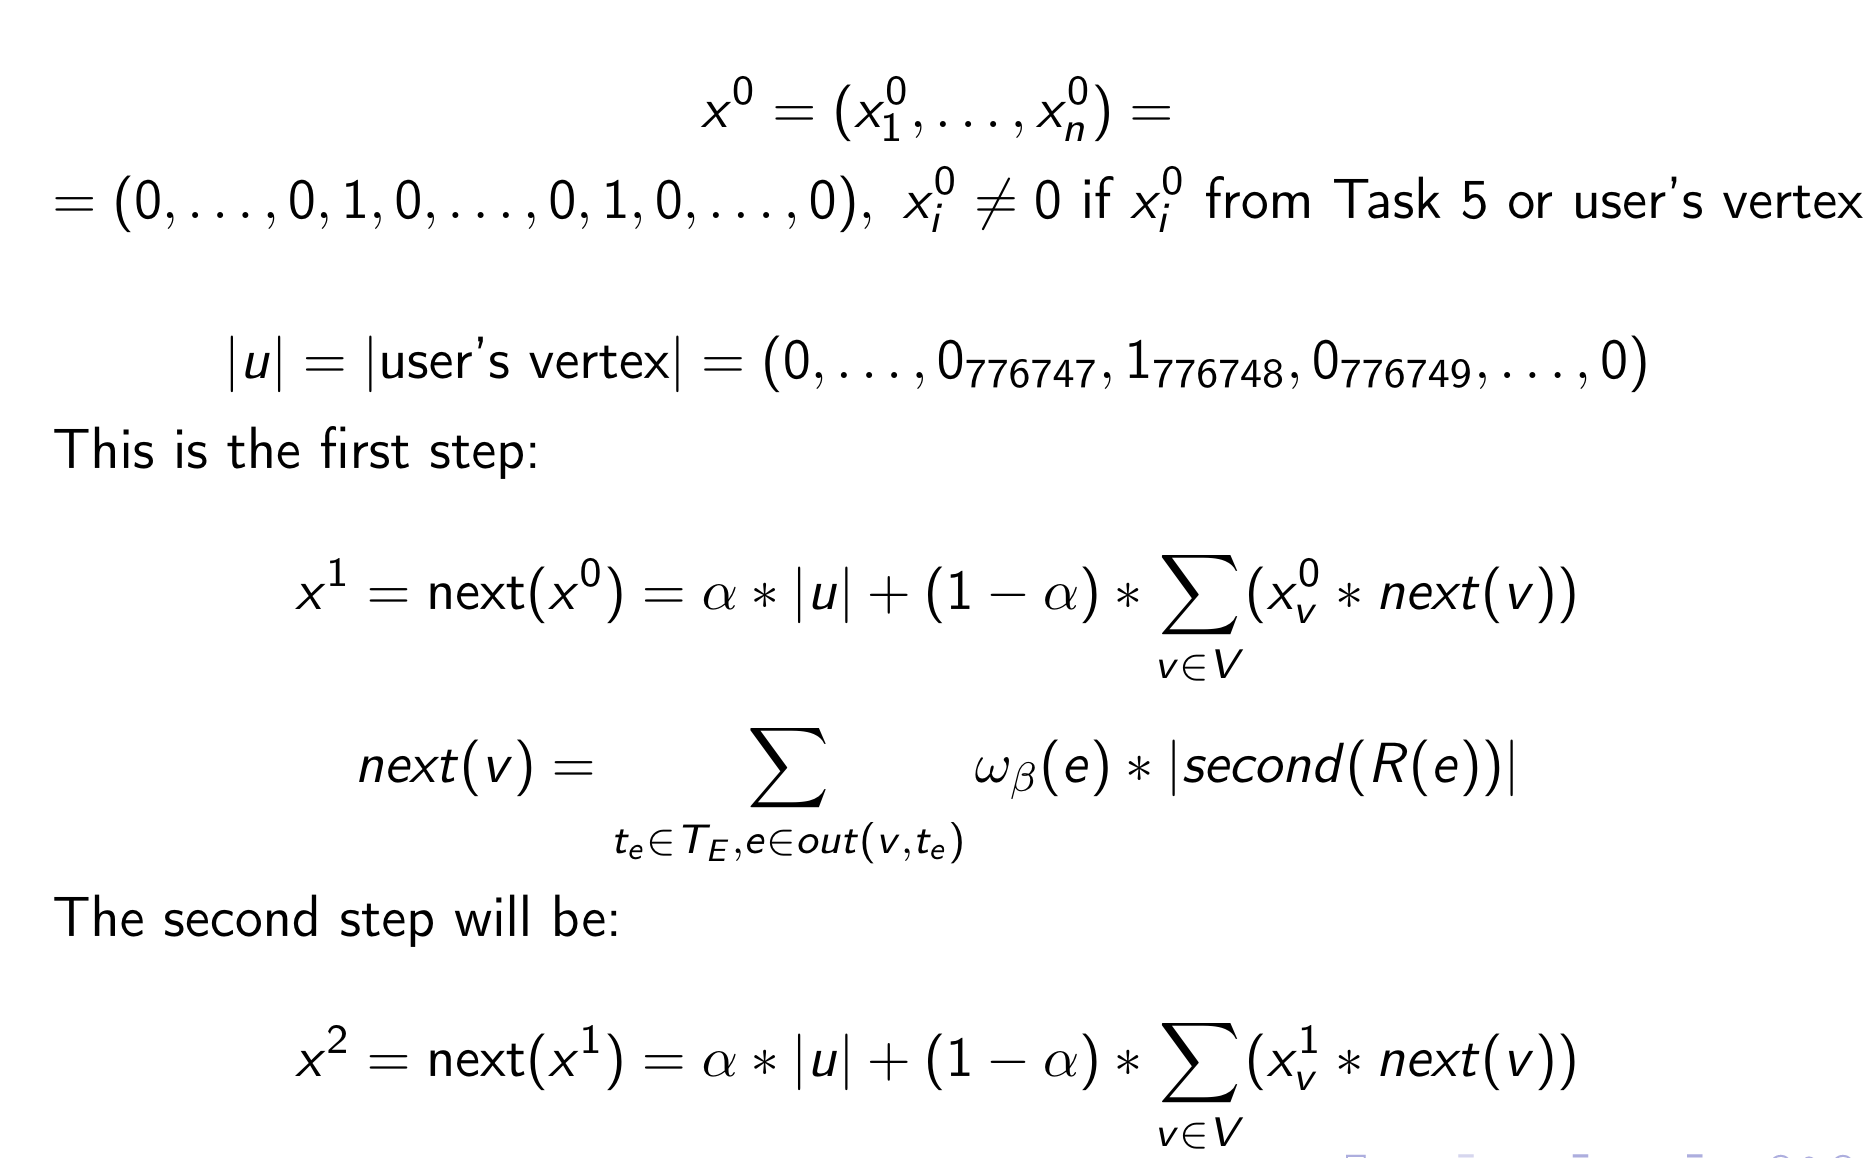

Take alpha = 0.15. and the next balancing functions:

- beta(user, user → artist) = 0.5
- beta(user, user → track) = 0.5
- beta(track, track → track) = 1
- beta(artist, artist → track) = 1

You should receive a table with 3 columns: “name”, “artist” and “rank”. Sort the resulting dataframe in descending order by “rank”, select top 40 recommended tracks, select only the columns “name”, “artist” and “rank”, leave 5 digits after the decimal point in “rank” and print the resulting dataframe.

**The part of the result on the sample dataset:**

`...
Prayer Of The Refugee Artist: Rise Against 1.35278102029
Eagle Artist: Gotthard 1.21412311013
21 Guns Artist: Green Day 1.17301653219
Wait And Bleed Artist: Slipknot 0.921552328559
Beautiful disaster Artist: 311 0.921552328559
...`

In [133]:
edges = (trackTrack
         .union(userTrack)
         .union(userArtist)
         .union(artistTrack)
        ).cache()

In [138]:
userData = data.filter(col("userId") == user);

users = (data
         .select(col("userId").alias("id"))
         .distinct()
         .withColumn("p", when(col("id") == user, 1.0).otherwise(0.0))
        )

tracks = (data
          .select(col("trackId").alias("id"))
          .distinct()
          .join(userData.select(col("trackId").alias("id"), lit(1).alias("tmp")).distinct(), "id", "left")
          .withColumn("p", when(~col("tmp").isNull(), 1.0).otherwise(0.0))
          .select(col("id"), col("p"))
         )

artists = (data
           .select(col("artistId").alias("id"))
           .distinct()
           .join(userData.select(col("artistId").alias("id"), lit(1).alias("tmp")).distinct(), "id", "left")
           .withColumn("p", when(~col("tmp").isNull(), 1.0).otherwise(0.0))
           .select(col("id"), col("p"))
         )

x = (users
     .union(artists)
     .union(tracks)
    ).cache()

In [141]:
u = (x
     .withColumn("u_prob", when(col("id") == user, 1.0).otherwise(0.0))
     .select("id", "u_prob") 
    ).cache()


for _ in range(5):
    sigma = (x
             .join(edges, col("id") == col("id1"), "left")
             .na.fill(0.0, ["next_value"])
             .withColumn("acc", col("p") * col("next_value"))
             .groupBy("id2")
             .agg(sum("acc").alias("sigma"))
            )
    x = (u
         .join(sigma, col("id") == col("id2"), "left")
         .na.fill(0.0, ["sigma"])
         .withColumn("next_value", alpha*col("u_prob") + (1-alpha) * col("sigma"))
         .select(col("id"), col("next_value").alias("p"))
        ).cache()

In [149]:
recommendDF = (x
          .filter(col("id") != str(user))
          .join(meta, on="id")
          .orderBy(col("p").desc())
          .select(col("Name"), col("Artist"), round(col("p"), 5).alias("p"))
         ).cache().take(40);

In [145]:
for val in recommendDF:
    print ("%s %s %s" % val)

I Hate Everything About You Artist: Three Days Grace 0.19694
Kill The DJ Artist: Green Day 0.18672
Come Out and Play Artist: The Offspring 0.18658
21 Guns Artist: Green Day 0.16066
Prayer Of The Refugee Artist: Rise Against 0.1546
Eagle Artist: Gotthard 0.1546
Nothing Going On Artist: Clawfinger 0.10735
Here To Stay Artist: Korn 0.10309
Hard Rock Hallelujah Artist: Lordi 0.10309
Beautiful disaster Artist: 311 0.10271
In The End Artist: Linkin Park 0.10271
Wait And Bleed Artist: Slipknot 0.10271
Numb Artist: Linkin Park 0.10271
Sky is Over Artist: Serj Tankian 0.05617
Kryptonite Artist: 3 Doors Down 0.05617
Girls and Boys Artist: Blur 0.05236
Take It Out On Me Artist: Thousand Foot Krutch 0.05236
Cocaine Artist: Nomy 0.02803
Getting Away With Murder Artist: Papa Roach 0.02793
Artist: Green Day Artist: Green Day 0.01181
Artist: Clawfinger Artist: Clawfinger 0.00472
Artist: The Offspring Artist: The Offspring 0.00472
Artist: Linkin Park Artist: Linkin Park 0.00472
Artist: Iggy Pop Artist: